### Binary classification on misinfo labels

In [1]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import numpy as np
from catboost import Pool, cv, CatBoostClassifier
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

Text(0, 0.5, 'Count')

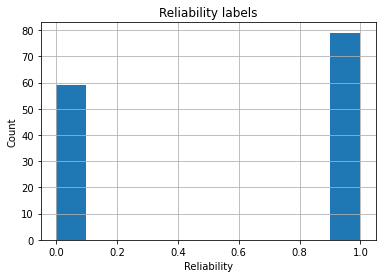

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv ('politifact_seo_attributes.csv')
# load labels
df_labels = pd.read_csv('domains.csv')

df_filtered = df.copy()#[df['label'].isin([1,3])]r
df_filtered.reset_index(drop=True, inplace=True)
# df_filtered.loc[df_filtered["label"] == 1, "label"] = 2 # FOR GRAPHING
# df_filtered['label']
fig, ax = plt.subplots()
df_labels.hist(column=' fake',ax = ax, align='mid')
# fig.suptitle('Reliability labels')
ax.set_title('Reliability labels')
ax.set_xlabel('Reliability')
ax.set_ylabel('Count')


In [3]:
# df_filtered = df_filtered.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 2241)))
dropped_cols = ['url']#, 'edu', 'gov','ugc' ]
# dropped_attrs = ['edu', 'gov']
# df_filtered.drop(columns=dropped_attrs, inplace=True)
X = df_filtered.drop(columns = dropped_cols)#[['backlinks',	'text',	'image',	'nofollow',	'redirect',		'gov',	'edu',	'refdomains']]
y = df_labels[' fake']


In [4]:
import os
import csv
from urllib.parse import urlparse

def count_domain_occurrences(folder_path):
    domain_counts = {}
    
    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            
            # Open the CSV file
            with open(file_path, "r") as file:
                csv_reader = csv.reader(file)
                # Iterate over each row in the CSV
                for row in csv_reader:
                    url = row[0]
                    parsed_url = urlparse(url)
                    domain = parsed_url.netloc
                    if domain == None or domain == '':
                        continue
                    if domain.startswith('www.'):
                        domain = domain[4:]    
                        # Count the occurrences of each domain
                    if domain in domain_counts:
                        domain_counts[domain] += 1
                    else:
                        domain_counts[domain] = 1
    
    return domain_counts

fake_domains = count_domain_occurrences('data/PoliticalNews/1/')
news_domains = count_domain_occurrences('data/PoliticalNews/0/')

In [5]:
domain_counts = {**fake_domains, **news_domains}
df_domain_counts = pd.DataFrame.from_dict(domain_counts, orient='index')
df_domain_counts.reset_index(inplace=True)
df_domain_counts.columns=['url', 'count']

df_filtered_counts = df_filtered.merge(df_domain_counts, on='url', how='inner')

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, auc, roc_curve

clfs = {
    # "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    # "RF": RandomForestRegressor(n_estimators=50, random_state=0),
    # "DT": DecisionTreeClassifier(random_state=0),
    # "MLP": MLPClassifier(random_state=0, max_iter=200, hidden_layer_sizes=(200,200)),
    # "SVM": svm.SVC(kernel='poly'),
}

false_positives = []
false_negatives = []
kf = KFold(n_splits=5, shuffle=True)

results = {}

_X = X.to_numpy()
_y = y.to_numpy()
_counts = df_filtered_counts['count'].to_numpy()

for clf_name in clfs.keys():
    rs = []
    f1s = []
    ps = []
    accs = []
    aucs = []
    for train_index, test_index in kf.split(_X, _y):
        X_train, X_test = _X[train_index], _X[test_index]
        y_train, y_test, counts = _y[train_index], _y[test_index], _counts[test_index]
        clf = clfs[clf_name]
        clf = clf.fit(X_train, y_train)
        scores = np.rint(clf.predict(X_test)).astype(int)

        tp = np.sum((scores & y_test) * counts)
        fn = np.sum((scores & (1 - y_test)) * counts)
        fp = np.sum(((1-scores) & y_test) * counts)
        total = np.sum(y_test*counts)

        P = tp / (tp + fp)
        R = tp / (tp + fn)
        F1 = 2*P*R/(P+R)
        ACC = tp / total
        accs.append(ACC)
        f1s.append(F1)
        rs.append(R)
        ps.append(P)

        scores_repeated = np.repeat(scores, counts)
        test_repeated = np.repeat(y_test, counts)
        fpr, tpr, _ = roc_curve(y_test, np.rint(scores))
        aucs.append(auc(fpr, tpr))
        # if clf_name == 'Boosted DT':
        #     false_positives = (predictions == 1) & (y_test == 0)
        #     false_negatives = (predictions == 0) & (y_test == 1)
    results[clf_name] = {}
    results[clf_name]['F1'] = {np.mean(f1s)}
    results[clf_name]['R'] = {np.mean(rs)}
    results[clf_name]['P'] = {np.mean(ps)}
    results[clf_name]['AUC'] = {np.mean(aucs)}
    results[clf_name]['ACC'] = {np.mean(accs)}
    print(clf_name + ': P: ' + str(np.mean(ps)) + f", F1: {np.mean(f1s)}, R: {np.mean(rs)}, ACC: {np.mean(accs)}, AUC: {np.mean(aucs)}")


In [7]:
from pprint import pprint
rounded = {}
for alg in results:
    rounded[alg] = {}
    for metric in ['ACC','AUC']:
        rounded[alg][metric] = round(list(results[alg][metric])[0], 2)
pprint(rounded, )

{}


### Feature Importances

In [39]:
import matplotlib.pyplot as plt

def plot_co_importances(features, importances_a, name_a, importances_b, name_b):
    plt.figure(figsize=(20, 3))
    plt.bar(range(len(features)), importances_b, tick_label=features, alpha=0.6, color='#da291c', label=name_b)
    plt.bar(range(len(features)), importances_a, tick_label=features, alpha=0.6, color='#003da5', label=name_a)
    plt.xticks(rotation = 45)
    plt.title('Reliability Feature Importances')
    plt.legend()
    plt.grid()


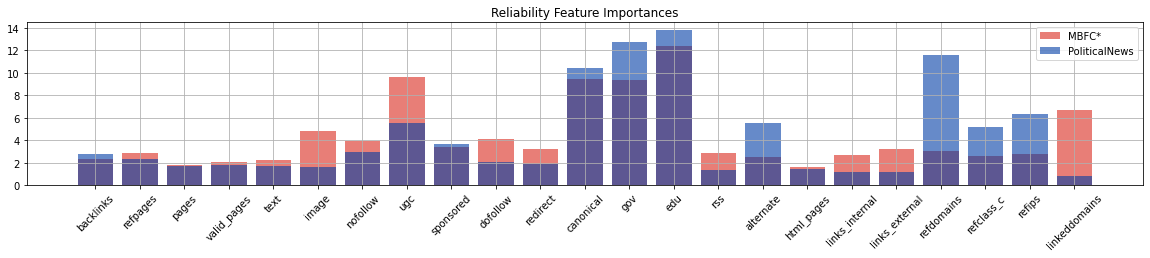

In [40]:
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_filtered.index, test_size=0.2, shuffle=True, random_state=24)
cat_clf_politi = CatBoostClassifier(verbose=False, depth = 5)
cat_clf_politi = cat_clf_politi.fit(X_train, y_train)
features = X_train.columns
features = list(features)
features[-1] = 'linkeddomains'
cat_clf_mbfc = CatBoostClassifier().load_model('../flat_models/model_misinfo_mbfc')
plot_co_importances(features, cat_clf_politi.get_feature_importance(), 'PoliticalNews', cat_clf_mbfc.get_feature_importance(), 'MBFC*')
plt.savefig('../results/fig/reliability_feature_importances.png', bbox_inches='tight', dpi=300)